In [222]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import time
import chess
import chess.engine
import chess.svg
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output

import warnings
warnings.filterwarnings('ignore')

In [223]:
# def random_board(max_depth=200):
#     board = chess.Board()
#     depth = random.randrange(0, max_depth)

#     for _ in range(1):
#         all_moves = list(board.legal_moves)
#         random_move = random.choice(all_moves)
#         board.push(random_move)
#         if board.is_game_over():
#             break
        
#     return board

# board = random_board()
# board

In [224]:
class ChessNN(nn.Module):
    def __init__(self):
        super(ChessNN, self).__init__()
        self.fc1 = nn.Linear(64 * 12, 256)  # Simple one-hot encoding of the board
        self.fc2 = nn.Linear(256, 64 * 64)  # Outputting one value for each possible move (simplified)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [225]:
def board_to_tensor(board):
    board_tensor = np.zeros((12, 8, 8), dtype=np.float32)
    piece_to_idx = {'p': 0, 'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5,
                    'P': 6, 'N': 7, 'B': 8, 'R': 9, 'Q': 10, 'K': 11}
    for i in range(64):
        piece = board.piece_at(i)
        if piece is not None:
            piece_idx = piece_to_idx.get(piece.symbol(), -1)
            if piece_idx != -1:
                row, col = divmod(i, 8)
                board_tensor[piece_idx, row, col] = 1
    return board_tensor.flatten()


In [226]:
def select_move(model, board, epsilon=0.2):
    legal_moves = list(board.legal_moves)
    if not legal_moves:
        return None, 0
    if random.random() < epsilon:  # Exploration
        move = random.choice(legal_moves)
        return move, 0  # Score for random moves is 0
    else:  # Exploitation
        board_tensor = torch.FloatTensor([board_to_tensor(board)])
        with torch.no_grad():
            predictions = model(board_tensor).view(64, 64)
        move_scores = {move: predictions[move.from_square, move.to_square].item() for move in legal_moves}
        best_move = max(move_scores, key=move_scores.get)
        return best_move, move_scores[best_move]

In [227]:
def get_move_reward(board, move):
    reward = 0
    if board.is_capture(move):
        captured_piece = board.piece_at(move.to_square)
        piece_value = {'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K': 0.1}
        reward += piece_value.get(captured_piece.symbol().upper(), 0)

    # Additional rewards/penalties could be added here based on strategic positions etc.
    return reward

def get_game_reward(result):
    # Defines reward based on the game result
    if result == "1-0":  # White wins
        return 1
    elif result == "0-1":  # Black wins
        return -1
    else:  # Draw
        return 0

In [228]:
def plot_training(losses, white_scores, black_scores, nn_move_counts, random_move_counts, fig, axs, window=10):
    if fig is None or axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Smooth losses
    if len(losses) >= window:
        smoothed_losses = np.convolve(losses, np.ones(window) / window, mode='valid')
    else:
        smoothed_losses = losses  # Not enough data to smooth, use raw data

    # Plotting Training Losses
    axs[0].clear()
    axs[0].plot(smoothed_losses, label='Loss (smoothed)', color='purple')
    axs[0].set_title('Training Loss')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plotting Move Counts by Type
    axs[1].clear()
    axs[1].plot(random_move_counts, label='Random Moves Count', color='orange')
    axs[1].plot(nn_move_counts, label='NN Moves Count', color='blue')
    axs[1].set_title('Move Counts by Type')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Average Count')
    axs[1].legend()

    # Plotting Scores by Player
    axs[2].clear()
    axs[2].plot(white_scores, label='White Score', color='lightblue')
    axs[2].plot(black_scores, label='Black Score', color='gray')
    axs[2].set_title('Score Tracking by Player')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Score')
    axs[2].legend()

    clear_output(wait=True)
    display(fig)

    return fig, axs


In [229]:
def train_model(model, optimizer, episodes=50, gamma=0.9):
    loss_fn = torch.nn.MSELoss()
    data = []
    losses, white_scores, black_scores, nn_move_counts, random_move_counts = [], [], [], [], []
    fig, axs = None, None

    for episode in range(episodes):
        board = chess.Board()
        game_history = []
        episode_moves = [] 
        white_score = black_score = 0
        nn_count = random_count = 0

        while not board.is_game_over():
            epsilon = max(0.1, 1 - episode / episodes)
            move, score = select_move(model, board, epsilon)
            if not move:
                break
            board.push(move)
            game_state = board_to_tensor(board)
            game_history.append((game_state, move))

            move_type = "random" if score == 0 else "NN"
            if move_type == "random":
                random_count += 1
            else:
                nn_count += 1
            
            move_detail = {
                "move": move.uci(),
                "type": "random" if score == 0 else "NN",
                "score": score if score != 0 else None
            }
            episode_moves.append(move_detail)

            move_reward = get_move_reward(board, move)
            if board.turn == chess.BLACK:  # White just moved
                white_score += move_reward
            else:
                black_score += move_reward

        result = board.result()
        reward = get_game_reward(result)
        total_loss = 0

        for state, move in reversed(game_history):
            current_state_tensor = torch.FloatTensor([state])
            target_reward = torch.tensor([reward], dtype=torch.float32)
            predicted_reward = model(current_state_tensor)
            loss = loss_fn(predicted_reward, target_reward)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            reward = reward * gamma
            total_loss += loss.item()

        losses.append(total_loss)
        white_scores.append(white_score)
        black_scores.append(black_score)
        nn_move_counts.append(nn_count / max(1, len(game_history)))  # Normalize by total moves made
        random_move_counts.append(random_count / max(1, len(game_history)))  # Normalize by total moves made

        data.append({
            "Episode": episode + 1,
            "Loss": total_loss,
            "Result": result,
            "Winner": 'White' if result == '1-0' else 'Black' if result == '0-1' else 'Draw',
            "White Score": white_score,
            "Black Score": black_score,
            "NN Move Count": nn_count,
            "Random Move Count": random_count,
            "Moves": episode_moves
        })

        # Update plots real-time
        if (episode % 10 == 0 or episode == episodes - 1) and episode > 100:
            fig, axs = plot_training(losses, white_scores, black_scores, nn_move_counts, random_move_counts, fig, axs)
        else:
            fig, axs = plot_training(losses, white_scores, black_scores, nn_move_counts, random_move_counts, fig, axs)

        print(f"Episode {episode + 1}: Loss = {total_loss:.4f}, Result = {result}, Winner = {'White' if result == '1-0' else 'Black' if result == '0-1' else 'Draw'}, Moves Count = {len(episode_moves)}, Moves = {episode_moves}")

    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(data)
    return df


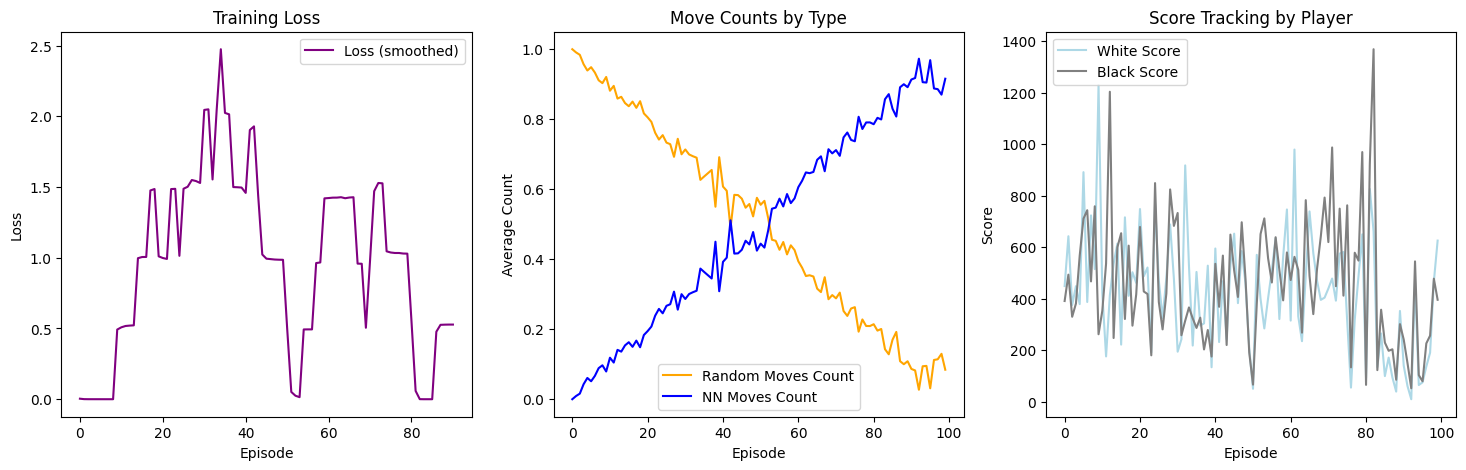

Episode 100: Loss = 0.0002, Result = 1/2-1/2, Winner = Draw, Moves Count = 261, Moves = [{'move': 'b1c3', 'type': 'NN', 'score': 0.00251043401658535}, {'move': 'c7c5', 'type': 'NN', 'score': 0.0005752411670982838}, {'move': 'f2f3', 'type': 'NN', 'score': -0.0008123626466840506}, {'move': 'd7d5', 'type': 'NN', 'score': -0.0020930753089487553}, {'move': 'f3f4', 'type': 'NN', 'score': -0.0007966064149513841}, {'move': 'b8d7', 'type': 'NN', 'score': -6.895605474710464e-05}, {'move': 'd2d4', 'type': 'NN', 'score': -0.0015491615049540997}, {'move': 'a7a5', 'type': 'NN', 'score': -0.0004667234607040882}, {'move': 'g1f3', 'type': 'NN', 'score': -0.0020934578496962786}, {'move': 'g8f6', 'type': 'NN', 'score': -0.0021519579458981752}, {'move': 'f3g5', 'type': 'NN', 'score': -0.0018958670552819967}, {'move': 'b7b6', 'type': 'NN', 'score': -0.00219753198325634}, {'move': 'g5f3', 'type': 'NN', 'score': -0.0021673778537660837}, {'move': 'g7g5', 'type': 'NN', 'score': -0.002198432572185993}, {'move':

In [230]:
model = ChessNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
results = train_model(model, optimizer, episodes=100)


In [231]:
episode_column = results['Episode']
loss_column = results['Loss']
result_column = results['Result']
white_score_column = results['White Score']
black_score_column = results['Black Score']
nn_move_count_column = results['NN Move Count']
random_move_count_column = results['Random Move Count']
moves_column = results['Moves']

In [232]:
results.head(5)
# with pd.option_context('display.max_colwidth', None):
#     print(results)

,Episode,Loss,Result,Winner,White Score,Black Score,NN Move Count,Random Move Count,Moves
0,1,0.030686,1/2-1/2,Draw,448.7,390.7,0,268,"[{'move': 'd2d4', 'type': 'random', 'score': N..."
1,2,0.004365,1/2-1/2,Draw,642.1,493.0,4,435,"[{'move': 'c2c3', 'type': 'random', 'score': N..."
2,3,0.000514,1/2-1/2,Draw,375.4,329.5,6,369,"[{'move': 'e2e3', 'type': 'NN', 'score': 0.000..."
3,4,0.000335,1/2-1/2,Draw,448.3,380.8,11,246,"[{'move': 'h2h3', 'type': 'random', 'score': N..."
4,5,0.000379,1/2-1/2,Draw,378.7,566.6,20,309,"[{'move': 'f2f4', 'type': 'random', 'score': N..."


In [233]:
torch.save(model.state_dict(), 'chess_model.pth')
print("Model saved successfully.")


Model saved successfully.


In [234]:
model = ChessNN()
model.load_state_dict(torch.load('chess_model.pth'))
model.eval()
print("Model loaded and set to evaluation mode.")


Model loaded and set to evaluation mode.


In [235]:
def watch_model_play(model, ignore_draws=False, ignore_fivefold_repetition=False, ignore_seventyfive_moves=False):
    board = chess.Board()
    move_count = 0
    while True:
        if move_count > 250:
            print("Stopping due to too many moves")
            break

        if board.is_game_over():
            if board.is_checkmate():
                print("Checkmate.")
                break
            elif not ignore_draws:
                # Directly print out why a draw has been claimed
                if board.can_claim_draw():
                    print("Draw can be claimed.")
                if board.is_stalemate():
                    print("Stalemate reached.")
                if board.is_insufficient_material():
                    print("Insufficient material for a checkmate.")
                if not ignore_seventyfive_moves and board.is_seventyfive_moves():
                    print("75-move rule reached.")
                if not ignore_fivefold_repetition and board.is_fivefold_repetition():
                    print("Fivefold repetition reached.")
                if board.is_variant_draw():
                    print("Draw by variant-specific rules.")
                break

        result = select_move(model, board, epsilon=0)
        if result is None:
            print("No legal moves available")
            break
        move, score = result
        board.push(move)
        clear_output(wait=True)
        display(HTML(chess.svg.board(board=board, lastmove=move, size=400)))
        print("Move:", move.uci())
        print("White to move" if board.turn else "Black to move")
        time.sleep(.1)  # Increase delay for visibility
        move_count += 1

    print(f"\nGame result: {board.result()}")
    print("Move Count:", move_count)

# Testing with draw conditions
watch_model_play(model, ignore_draws=True, ignore_fivefold_repetition=True, ignore_seventyfive_moves=True)


Move: c3b4
Black to move
Stopping due to too many moves

Game result: 1/2-1/2
Move Count: 251


This is working as a foundation, but the problem seems that the training and scoring for moves needs to be refactored. The AI is moving the pieces back and fourth without getting penalized, when it should be trying different moves. Maybe we put in a threshold when it gets above certain moves then it can start moving the same piece from the previous move. 

Issue is most games end in a draw.